In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)

# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

In [2]:
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

# Contents
- [Cleaning Train Dataset](#Cleaning-Train-Dataset)
- [Cleaning Test Dataset](#Cleaning-Test-Dataset)
- [Cleaning Weather Dataset](#Cleaning-Weather-Dataset)
- [Cleaning Spray Dataset](#Cleaning-Spray-Dataset)

## Cleaning Train & Test Dataset

In [3]:
train.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
# convert all to lower case
train.columns = [word.lower() for word in train.columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10506 non-null  object 
 1   address                 10506 non-null  object 
 2   species                 10506 non-null  object 
 3   block                   10506 non-null  int64  
 4   street                  10506 non-null  object 
 5   trap                    10506 non-null  object 
 6   addressnumberandstreet  10506 non-null  object 
 7   latitude                10506 non-null  float64
 8   longitude               10506 non-null  float64
 9   addressaccuracy         10506 non-null  int64  
 10  nummosquitos            10506 non-null  int64  
 11  wnvpresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


Check null

In [6]:
# no null values 
train.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
dtype: int64

<AxesSubplot:>

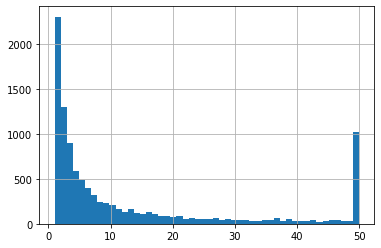

In [7]:
# Distribution of mosquitos found

train['nummosquitos'].hist(bins=50) # Ceiling at 50 is reflective of how the data is entered

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50.

**Assumption**<br/>
If the mosquito traps are only inspected ONCE a day, we will only expect more than one entry for the specific location/trap/date if one of the entry has 50 mosquitos.

In [8]:
# Create a list of columns without 'nummosquitos'

col_w = list(train.columns)
col_w.remove('nummosquitos') # this includes all the column names except for 'nummosquitos'

In [9]:
# Inspect dulplicated rows where number of mosquito count is less than 50

mos_u50 = train.loc[train['nummosquitos']<50,:] # slice data for nummosquitos < 50

dup = mos_u50[col_w].duplicated(keep=False) # find index of data which have same are duplicates except 'nummosquitos'

In [10]:
# View some data which are duplicates except 'nummosquitos'

mos_u50[dup][:6] 

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
98,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
280,2007-07-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
281,2007-07-11,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,2,0
294,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,35,0
296,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,8,0


There are entries that have the same date, location, trap with different number of mosquitos.

This means that the data is not entered as we expect. These could be due to data entry errors, traps are checked more than once a day or others. However, it is impossible to discern. We will assume that all datapoints are VALID. (ie. traps are checked several times a day or additional rows are proximity traps)

In [11]:
# To merge rows if they have the same date, location, trap
# Create new column to identify those with wnv

col_w.remove('wnvpresent') # ie all columns except wnvpresent and nummosquitos

train_1 = train.groupby(col_w, as_index=False).sum()

# Refresh 'wnvpresent' variable (ie if wnvpresent or not)
train_1['wnvpresent'] = train_1['wnvpresent'].map(lambda x: 1 if x > 0 else 0)

In [12]:
# base rate of wnvpresent AFTER transformation

train_1['wnvpresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

In [13]:
# Inspect mosquito species and WNY presence

train_1.groupby(['species'])['nummosquitos', 'wnvpresent'].agg({'nummosquitos': ['sum'],
                                                                'wnvpresent': ['sum', 'mean']})

C:\Users\Admin\AppData\Local\Temp\ipykernel_4624\1553443093.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_1.groupby(['species'])['nummosquitos', 'wnvpresent'].agg({'nummosquitos': ['sum'],


nummosquitos wnvpresent          
                                sum        sum      mean
species                                                 
CULEX ERRATICUS                   7          0  0.000000
CULEX PIPIENS                 44671        184  0.094359
CULEX PIPIENS/RESTUANS        66268        225  0.058808
CULEX RESTUANS                23431         48  0.020059
CULEX SALINARIUS                145          0  0.000000
CULEX TARSALIS                    7          0  0.000000
CULEX TERRITANS                 510          0  0.000000

Most of the mosquitos found are Culex Pipiens and Culex Restuans which are the only species which were detected to have the West Nile Virus. This is because this two species are more common in the US. However, as all the species of Culex indicated can potentially transmitt the virus, we will not differentiate them for the purposes of analysis.([CDC](https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf))

In [15]:
col_w.remove('species') # ie all columns except wnvpresent, nummosquitos amd species

train_2 = train_1.groupby(col_w, as_index=False).sum()

# Refresh 'wnvpresent' variable (ie if wnvpresent or not)
train_2['wnvpresent'] = train_2['wnvpresent'].map(lambda x: 1 if x > 0 else 0)

In [16]:
train_2['date'] = pd.to_datetime(train_2['date'])
train_2['year'] = train_2['date'].dt.year
train_2['month'] = train_2['date'].dt.month

Text(0, 0.5, 'Total Number of Mozzies by Year and Month')

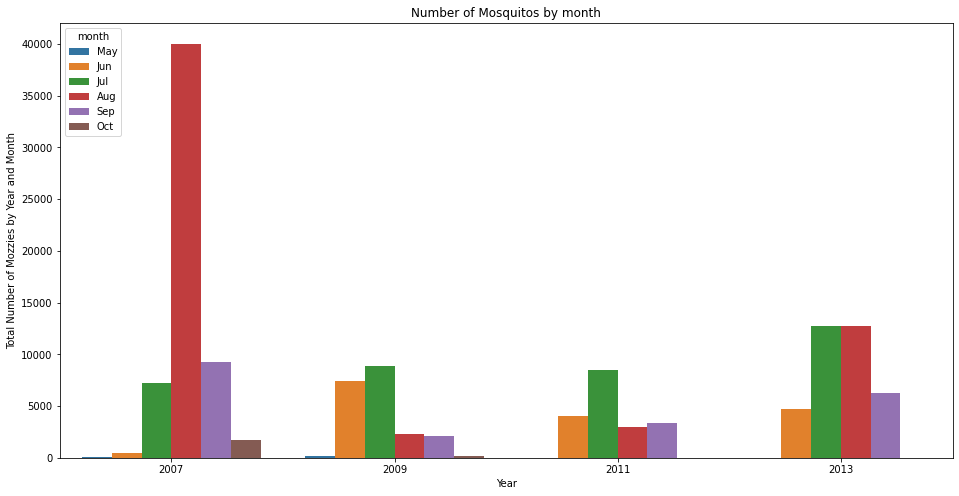

In [17]:
train_plot = train_2.copy()

train_plot = train_plot.groupby(["year", "month"], as_index=False).sum()
train_plot['month'] = train_plot['month'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})
plt.figure(figsize=(16, 8))
plt.title("Number of Mosquitos by month")
sns.barplot(x="year", y="nummosquitos", hue="month", data=train_plot)
plt.xlabel("Year")
plt.ylabel("Total Number of Mozzies by Year and Month")

There seem to be a cyclical trend across the years, particularly in August. Trend seems to be picking up from June to August. 

Text(0, 0.5, 'Total Number of Mozzies by Year and Month')

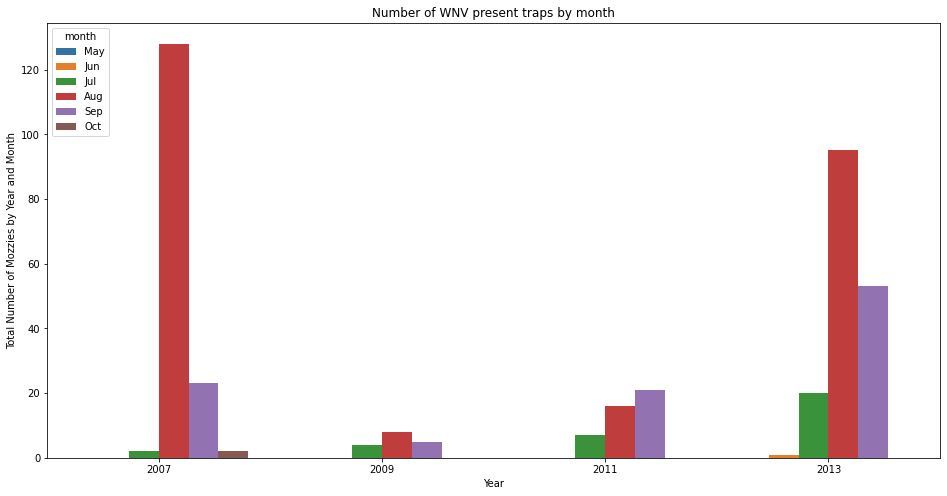

In [18]:
train_plot = train_2.copy()

train_plot = train_plot.groupby(["year", "month"], as_index=False).sum()
train_plot['month'] = train_plot['month'].map({5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'})
plt.figure(figsize=(16, 8))
plt.title("Number of WNV present traps by month")
sns.barplot(x="year", y="wnvpresent", hue="month", data=train_plot)
plt.xlabel("Year")
plt.ylabel("Total Number of Mozzies by Year and Month")

In [19]:
# Create a dataframe for each year with lat long and the cumulative occurence of virus
# col_w.remove('species')
to_keep = ['date', 'latitude', 'longitude', 'wnvpresent']

train_plot = train_2[to_keep].copy()

train_plot['date'] = pd.to_datetime(train_plot['date']) # convert date type
train_plot['year'] = train_plot['date'].dt.year         # create another column of date
train_plot.drop(columns='date', inplace=True)


train_plot = train_plot.groupby(['year', 'latitude', 'longitude']).sum() # collapse rows that have same values in columns col_w
train_plot.reset_index(inplace=True)    # create new df from those collapsed rows

train_plot.rename(columns={'wnvpresent': 'wnvcount', # Rename column names to the appropriate one
                       }, inplace=True)

train_plot_2007 = train_plot.loc[train_plot['year']==2007, :]
train_plot_2009 = train_plot.loc[train_plot['year']==2009, :]
train_plot_2011 = train_plot.loc[train_plot['year']==2011, :]
train_plot_2013 = train_plot.loc[train_plot['year']==2013, :]

Text(0.5, 1.0, 'Traps with WNV - 2013')

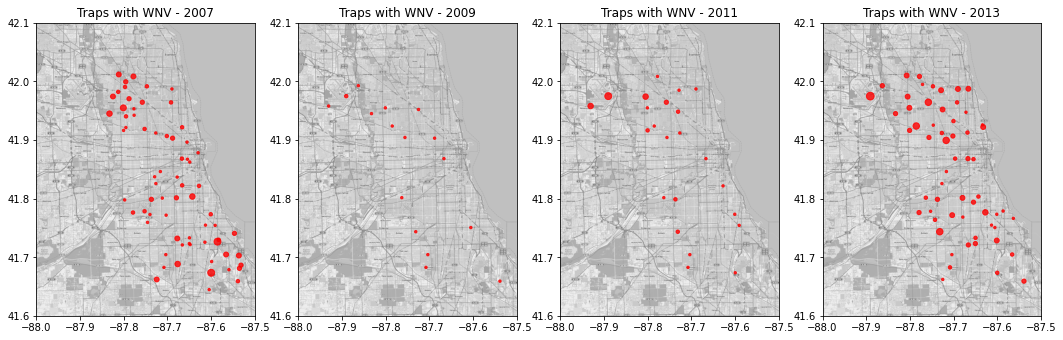

In [20]:
mapdata = np.loadtxt("../BackupData/mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../data/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)


# Plot for 2007
fig,ax = plt.subplots(figsize=(18,18), nrows=1, ncols=4)
ax[0].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2007 = train_plot_2007.loc[:, ['longitude', 'latitude']]

ax[0].scatter(locations_2007['longitude'], locations_2007['latitude'],
            s=train_plot_2007.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[0].set_title('Traps with WNV - 2007')


# Plot for 2009
ax[1].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2009 = train_plot_2009.loc[:, ['longitude', 'latitude']]

ax[1].scatter(locations_2009['longitude'], locations_2009['latitude'],
            s=train_plot_2009.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[1].set_title('Traps with WNV - 2009')

# Plot for 2011
ax[2].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2011 = train_plot_2011.loc[:, ['longitude', 'latitude']]

ax[2].scatter(locations_2011['longitude'], locations_2011['latitude'],
            s=train_plot_2011.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[2].set_title('Traps with WNV - 2011')

# Plot for 2013
ax[3].imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations_2013 = train_plot_2013.loc[:, ['longitude', 'latitude']]

ax[3].scatter(locations_2013['longitude'], locations_2013['latitude'],
            s=train_plot_2013.loc[:, ['wnvcount']]*6,
            alpha=0.8,
            c='red')
ax[3].set_title('Traps with WNV - 2013')

**To include annotation for graph above**

In [21]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    4616 non-null   datetime64[ns]
 1   address                 4616 non-null   object        
 2   block                   4616 non-null   int64         
 3   street                  4616 non-null   object        
 4   trap                    4616 non-null   object        
 5   addressnumberandstreet  4616 non-null   object        
 6   latitude                4616 non-null   float64       
 7   longitude               4616 non-null   float64       
 8   addressaccuracy         4616 non-null   int64         
 9   nummosquitos            4616 non-null   int64         
 10  wnvpresent              4616 non-null   int64         
 11  year                    4616 non-null   int64         
 12  month                   4616 non-null   int64   

In [22]:
# Transformation of test data

# To merge rows if they have the same date, location, trap
# Create new column to identify those with wnv
test.drop(columns=['Id'], inplace=True)

test.columns = [word.lower() for word in test.columns]

# remove species in test set
test_nospecies=test.drop(columns='species')
test_nospecies.drop_duplicates(keep='first', inplace=True, ignore_index=True)

# create month and year variabels for test_nospecies
test_nospecies['date'] = pd.to_datetime(test_nospecies['date'])
test_nospecies['year'] = test_nospecies['date'].dt.year
test_nospecies['month'] = test_nospecies['date'].dt.month

### Save cleaned train and test data to csv

In [23]:
# Save cleaned data to csv


train_1.to_csv(r'../data/train_clean.csv', index = False) # combine rows where date/location/trap is the same
                                                          # nummosquitos are summed
                                                          # wnvpresent = 1 if wnvpresent >0
train_2.to_csv(r'../data/train_clean_nospecies.csv', 
               index = False)                             # species is collapsed

test_nospecies.to_csv(r'../data/test_nospecies.csv', index = False)


In [24]:
##################################################

Check for no. of mosquitoes per trap

<AxesSubplot:xlabel='date'>

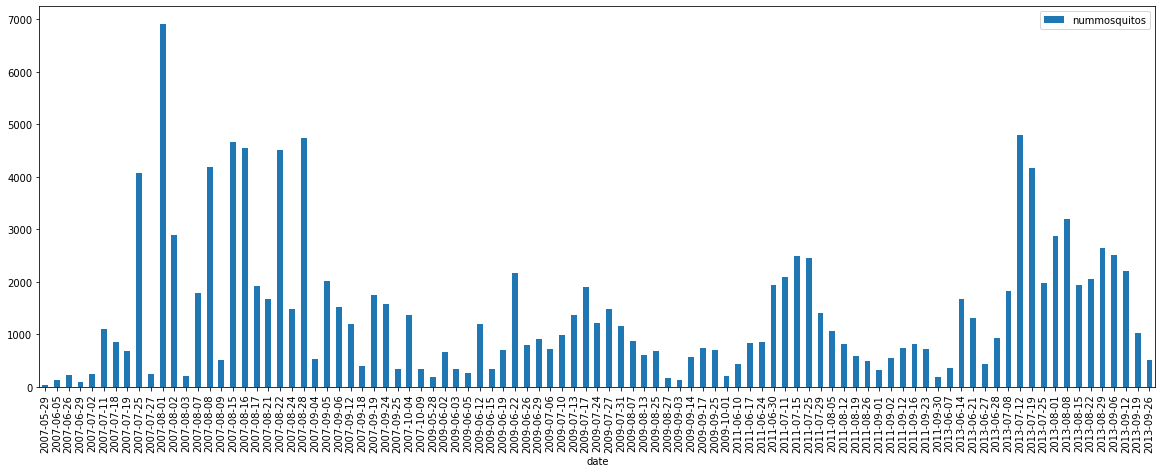

In [25]:
pd.pivot_table(train, values='nummosquitos', index=['date'], aggfunc=np.sum).plot.bar(figsize = (20,7))


In [30]:
def change_month(month):
    convert = month.to_pydatetime().month
    month_dict = {
        1: 'Jan',
        2: 'Feb',
        3: 'Mar',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: "Aug",
        9: 'Sept',
        10: 'Oct',
        11: 'Nov',
        12: 'Dec'
    }

    return month_dict[convert]

Text(0.5, 0, 'Total number of mosquitos per month')

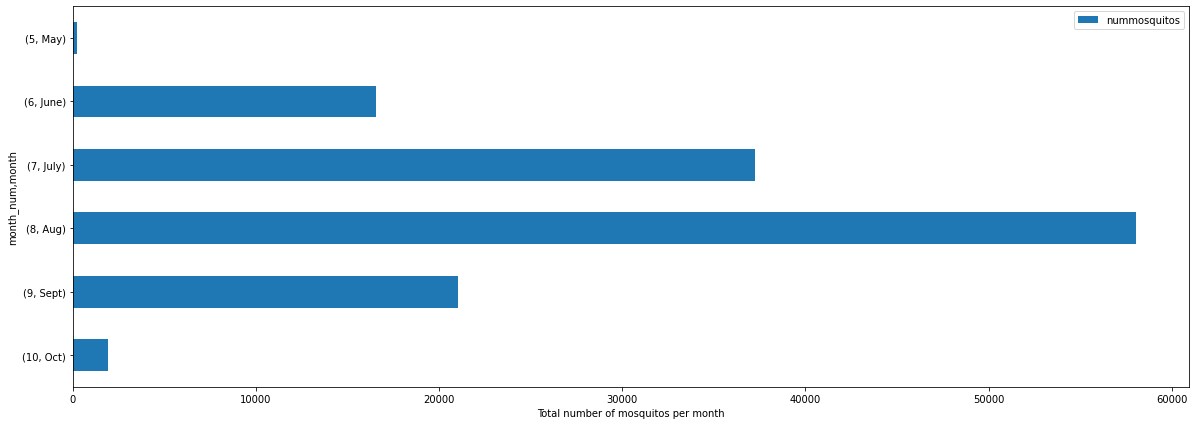

In [ ]:
pd.pivot_table(train, values='nummosquitos', index=['month_num','month'], aggfunc=np.sum).sort_values(by ='month_num', ascending = False).plot.barh(figsize = (20,7))

plt.xlabel('Total number of mosquitos per month')
plt.xlabel('Total number of mosquitos per month')


There seem to be a cyclical trend across the years, particularly in August. Trend seems to be picking up from June to August. 

In [ ]:
# Groupby species to check how many are present 

train.groupby('species')['wnvpresent'].sum()

species
CULEX ERRATICUS             0
CULEX PIPIENS             184
CULEX PIPIENS/RESTUANS    225
CULEX RESTUANS             48
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: wnvpresent, dtype: int64

3 out of the 7 groups of species are identified to have West Nile virus. Uniquely we have 2, mainly pipiens and restuans being prominent.  

<AxesSubplot:ylabel='trap'>

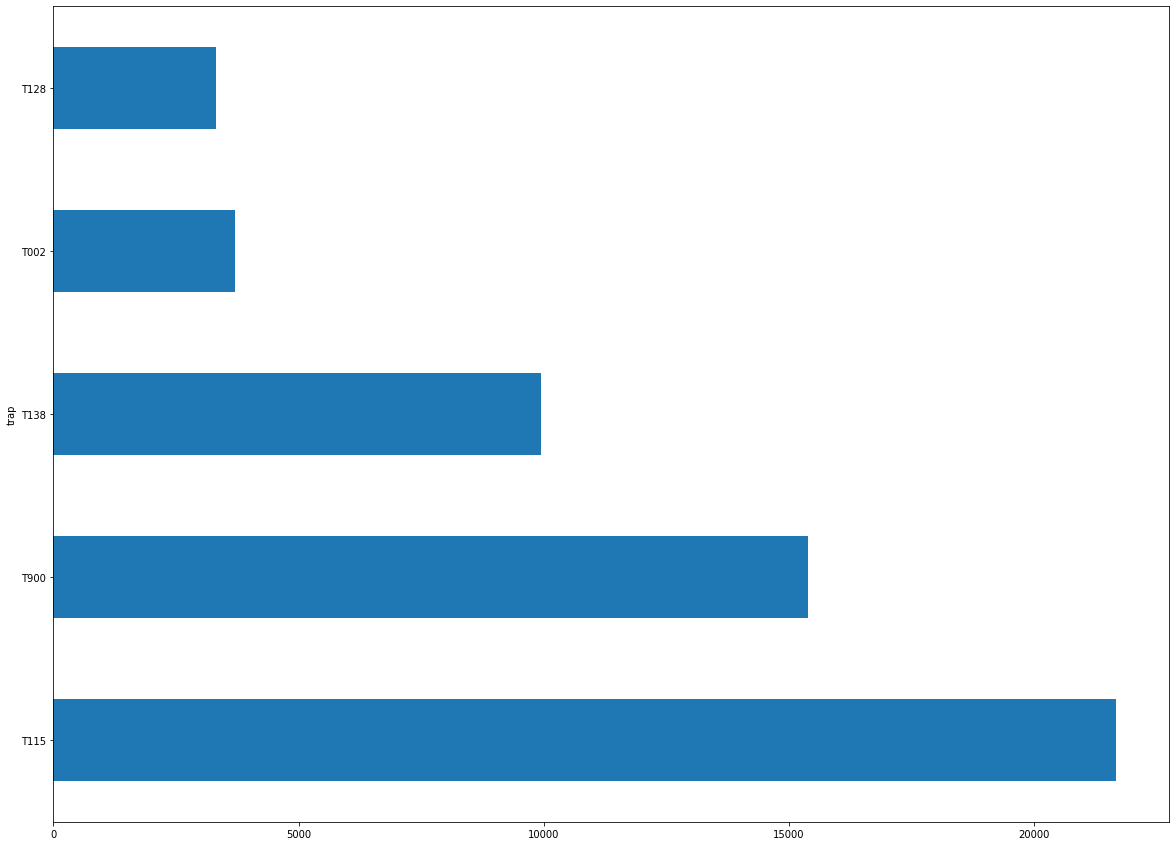

In [ ]:
train.groupby(['trap']).sum().sort_values(by = 'nummosquitos', ascending = False)['nummosquitos'].head(5).plot.barh(figsize = (20,15))

Top 5 highest mosquito counts coming from these 5 traps. 

## Cleaning Weather Dataset

In [137]:
weather.head(10)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [138]:
# convert all to lower case
weather.columns = [word.lower() for word in weather.columns]

In [139]:
# convert date time 
weather['date'] = weather['date'].map(lambda date: datetime.strptime(date, '%Y-%m-%d'))

In [140]:
# create month column 
weather['month'] = weather['date'].apply(change_month)

In [141]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       2944 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   object        
 8   heat         2944 non-null   object        
 9   cool         2944 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        2944 non-null   object        
 14  water1       2944 non-null   object        
 15  snowfall     2944 non-null   object        
 16  precip

In [142]:
print(f'Total rows for weather: {weather.shape[0]}\n')
for col in weather.columns:
    if 'M' in weather[col].unique().tolist():
        count = weather[col].value_counts()['M']
        print(f'Column {col} has {count} number of "M"');

Total rows for weather: 2944

Column tavg has 11 number of "M"
Column depart has 1472 number of "M"
Column wetbulb has 4 number of "M"
Column heat has 11 number of "M"
Column cool has 11 number of "M"
Column depth has 1472 number of "M"
Column water1 has 2944 number of "M"
Column snowfall has 1472 number of "M"
Column preciptotal has 2 number of "M"
Column stnpressure has 4 number of "M"
Column sealevel has 9 number of "M"
Column avgspeed has 3 number of "M"


### Approach to handle missing data

- `water1` need to drop as majority are missing values 
- `depart, depth, snowfall` have quite alot of missing values as well, need to see what are the unique values and its distribution to judge if it is usefull. 
- the `rest` will need to do imputation 

In [143]:
# drop water1 rows since majority is M  
weather.drop(columns='water1', inplace = True)

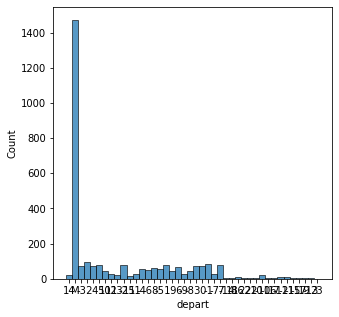

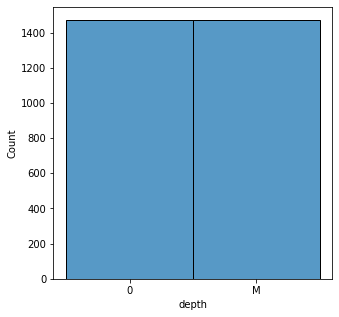

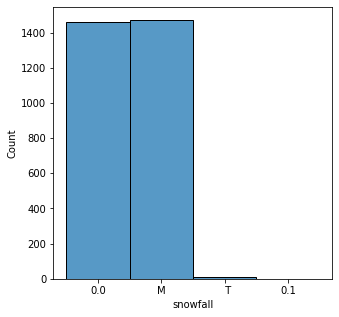

In [144]:
for col in ['depart','depth', 'snowfall']:
    plt.figure(figsize=(5,5))
    sns.histplot(x = col, data = weather)

Need to drop snowfall and depth since not much information to impute. 


In [145]:
# Dropping unnecessary columns.

cols_to_drop = ['depart', 'depth', 'snowfall']
weather.drop(columns=cols_to_drop, inplace=True)

In [146]:
# Replacing 'T's and 'M's with 0s in some columns.

weather.preciptotal.replace(['  T','M'], 0, inplace=True)
weather.wetbulb.replace(['M'], 0, inplace=True)
weather.heat.replace(['M'], 0, inplace=True)
weather.cool.replace(['M'], 0, inplace=True)
weather.stnpressure.replace(['M'], 0, inplace=True)
weather.sealevel.replace(['M'], 0, inplace=True)
weather.avgspeed.replace(['M'], 0, inplace=True)

In [147]:
# Calculate Tavg using (Tmax + Tmin)/2 to deal with 'M's in Tavg.

weather['tavg'] = (weather.tmax + weather.tmin)/2

In [148]:
# Changing column dtypes from type object to type float.

weather.preciptotal = weather.preciptotal.astype(float)
weather.wetbulb = weather.wetbulb.astype(float)
weather.heat = weather.heat.astype(float)
weather.cool = weather.cool.astype(float)
weather.stnpressure = weather.stnpressure.astype(float)
weather.sealevel = weather.sealevel.astype(float)
weather.avgspeed = weather.avgspeed.astype(float)

In [149]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   dewpoint     2944 non-null   int64         
 6   wetbulb      2944 non-null   float64       
 7   heat         2944 non-null   float64       
 8   cool         2944 non-null   float64       
 9   sunrise      2944 non-null   object        
 10  sunset       2944 non-null   object        
 11  codesum      2944 non-null   object        
 12  preciptotal  2944 non-null   float64       
 13  stnpressure  2944 non-null   float64       
 14  sealevel     2944 non-null   float64       
 15  resultspeed  2944 non-null   float64       
 16  result

In [150]:
# Grouping values from station 1 & 2 by `dates``.
# We take mean for the values measured by Station 1 and 2

weather_data_com = weather.groupby('date').mean()

In [151]:
# drop station column 

weather_data_com.drop(columns = 'station', inplace = True)

In [152]:
weather_data_com.head()

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
date,,,,,,,,,,,,,
2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,2.5,0.0,29.140,29.820,2.20,26.0,9.40
2007-05-02,59.5,42.5,51.00,42.0,47.0,13.5,0.0,0.0,29.410,30.085,13.15,3.0,13.40
2007-05-03,66.5,47.0,56.75,40.0,49.0,8.0,0.0,0.0,29.425,30.120,12.30,6.5,12.55
2007-05-04,72.0,50.0,61.00,41.5,50.0,3.5,0.0,0.0,29.335,30.045,10.25,7.5,10.60
2007-05-05,66.0,53.5,59.75,38.5,49.5,5.0,0.0,0.0,29.430,30.095,11.45,7.0,11.75


In [153]:
weather.sunrise.unique()

array(['0448', '-', '0447', '0446', '0444', '0443', '0442', '0441',
       '0439', '0438', '0437', '0436', '0435', '0434', '0433', '0432',
       '0431', '0430', '0429', '0428', '0427', '0426', '0425', '0424',
       '0423', '0422', '0421', '0420', '0419', '0418', '0417', '0416',
       '0440', '0445', '0449', '0450', '0451', '0452', '0453', '0454',
       '0455', '0456', '0457', '0458', '0459', '0500', '0501', '0502',
       '0503', '0504', '0505', '0506', '0508', '0509', '0510', '0511',
       '0512', '0513', '0514', '0515', '0516', '0517', '0518', '0519',
       '0520', '0521', '0522', '0523', '0524', '0525', '0526', '0527',
       '0528', '0529', '0530', '0531', '0532', '0533', '0535', '0536',
       '0537', '0538', '0539', '0540', '0541', '0542', '0543', '0544',
       '0545', '0546', '0547', '0548', '0549', '0550', '0552', '0553',
       '0554', '0555', '0556', '0557', '0558', '0559', '0600', '0602',
       '0603', '0604', '0605', '0606', '0607', '0608', '0610', '0611',
       '0

In [154]:
weather.sunset.unique()

array(['1849', '-', '1850', '1851', '1852', '1853', '1855', '1856',
       '1857', '1858', '1859', '1860', '1901', '1902', '1903', '1904',
       '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912',
       '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920',
       '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928',
       '1929', '1930', '1931', '1900', '1854', '1848', '1846', '1845',
       '1843', '1842', '1840', '1839', '1837', '1835', '1834', '1832',
       '1831', '1829', '1827', '1826', '1824', '1822', '1821', '1819',
       '1817', '1815', '1814', '1812', '1810', '1809', '1807', '1805',
       '1803', '1760', '1758', '1756', '1755', '1753', '1751', '1749',
       '1748', '1746', '1744', '1742', '1741', '1739', '1737', '1735',
       '1734', '1732', '1730', '1729', '1727', '1725', '1724', '1722',
       '1720', '1719', '1717', '1715', '1714', '1712', '1711', '1709',
       '1707', '1706', '1704', '1703', '1701', '1660', '1658', '1657',
       '1

Need to normalize 24h format to float 

In [155]:
# Define function to help convert 24h to float (0430 -->> 4.5)

def suntime_float(sun_time):
  
  # Getting the hour part of the time to convert to the whole number part in the float number.
  hours = sun_time // 100

  # Getting the minute part of the time to convert to the decimal part in the float number.
  minutes = (sun_time % 100) / 60

  return hours + minutes

merge with weather_data_com

In [156]:
# Creating series of sunrise and sunset times and converting them to dtype float.
sunrise_times = weather[weather['station']==1]['sunrise'].astype(float)
sunset_times = weather[weather['station']==1]['sunset'].astype(float)

# Mapping the above created function to convert 24h time values to floating point numbers.
weather_data_com['sunrise'] = list(sunrise_times.map(suntime_float))
weather_data_com['sunset'] = list(sunset_times.map(suntime_float))

Checking code sum should only have these based on Daily Table format given by Kaggle 

`FC` - Tornado

`FC` - Funnel Cloud

`TS` - Thunderstorm

`GR` - Hail

`RA` - Rain


In [157]:
weather['codesum'].unique()

array([' ', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG 

In [158]:
# Replacing string of weather conditions given in the codesum column.

weather['codesum'] = weather['codesum'].str.replace("BCFG","BC FG")
weather['codesum'] = weather['codesum'].str.replace("MIFG","MI FG")
weather['codesum'] = weather['codesum'].str.replace("TSRA","TS RA")
weather['codesum'] = weather['codesum'].str.replace("VCFG","VC FG")
weather['codesum'] = weather['codesum'].str.replace("VCTS","VC TS")

In [159]:
# Defining a function to clean the weather conditions given in Codesum column.

def clean_codesum(string):
    return " ".join(set(" ".join(string).split(' ')))

In [160]:
weather.groupby('date')['codesum'].agg(clean_codesum)

date
2007-05-01            
2007-05-02       BR HZ
2007-05-03          HZ
2007-05-04          RA
2007-05-05            
                ...   
2014-10-27          RA
2014-10-28          RA
2014-10-29            
2014-10-30          RA
2014-10-31    BR RA SN
Name: codesum, Length: 1472, dtype: object

In [161]:
codesum_groupedby_date = weather.groupby('date')['codesum'].agg(clean_codesum)

Merged codesum by date. Now need to vectorize


In [162]:
# Applying CountVectorizer to create dummy columns of each individual weather condition.

cvec = CountVectorizer(analyzer='word', token_pattern=r'[\w\+]+')
code_sum_cvec = cvec.fit_transform(codesum_groupedby_date)
code_sum_df = pd.DataFrame(code_sum_cvec.toarray(),weather['date'].unique(), columns=cvec.get_feature_names_out())
code_sum_df = code_sum_df.reset_index().rename( columns = {'index': 'date'})
code_sum_df

,date,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-03,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-04,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2007-05-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1468,2014-10-28,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1469,2014-10-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1470,2014-10-30,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [163]:
# check shape 

print(code_sum_df.shape)
print(weather_data_com.shape)

(1472, 15)
(1472, 15)


In [164]:
weather_data_com.reset_index(inplace = True)

In [165]:
cleaned_weather_df = weather_data_com.merge(code_sum_df, on = 'date')
cleaned_weather_df

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,sunrise,sunset,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-01,83.5,51.0,67.25,51.0,56.5,0.0,2.5,0.000,29.140,29.820,2.20,26.0,9.40,4.800000,18.816667,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,59.5,42.5,51.00,42.0,47.0,13.5,0.0,0.000,29.410,30.085,13.15,3.0,13.40,4.783333,18.833333,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-03,66.5,47.0,56.75,40.0,49.0,8.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,4.766667,18.850000,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-04,72.0,50.0,61.00,41.5,50.0,3.5,0.0,0.000,29.335,30.045,10.25,7.5,10.60,4.733333,18.866667,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2007-05-05,66.0,53.5,59.75,38.5,49.5,5.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,4.716667,18.883333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.25,51.5,58.5,0.5,1.0,0.010,28.960,29.665,12.35,19.0,13.25,6.300000,16.883333,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1468,2014-10-28,67.0,46.5,56.75,39.0,47.5,8.0,0.0,0.015,29.190,29.850,14.40,26.0,15.10,6.316667,16.850000,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1469,2014-10-29,49.0,38.0,43.50,33.0,41.0,21.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,6.333333,16.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1470,2014-10-30,52.0,34.5,43.25,34.5,41.0,21.5,0.0,0.000,29.375,30.095,5.50,23.5,6.00,6.366667,16.816667,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Save cleaned weather data to csv

In [166]:
# saving into weather_cleaned
cleaned_weather_df.to_csv(r'../data/weather_cleaned.csv', index = False)

### Further EDA on Weather dataset together train set

In [167]:
train = pd.read_csv('../data/train_cleaned.csv')
weather = pd.read_csv('../data/weather_cleaned.csv')

In [168]:
merge_train_weather = train.merge(weather, on = 'date', how = 'inner')

In [169]:
merge_train_weather.columns

Index(['Unnamed: 0', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvcount', 'wnvpresent', 'date_col', 'tmax', 'tmin',
       'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'sunrise', 'sunset', 'bc', 'br', 'dz', 'fg', 'fg+', 'fu', 'gr', 'hz',
       'mi', 'ra', 'sn', 'sq', 'ts', 'vc'],
      dtype='object')

In [170]:
merge_train_weather.drop(columns = ['Unnamed: 0'], inplace = True)

In [171]:
merge_train_weather['date'] = pd.to_datetime(merge_train_weather['date'])
merge_train_weather['year'] = merge_train_weather['date'].dt.year
merge_train_weather['month'] = merge_train_weather['date'].dt.month

Text(0, 0.5, 'Temperature')

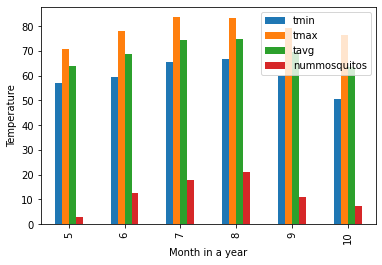

In [172]:
# monthly trend of average temperature
merge_train_weather.groupby('month').mean()[['tmin', 'tmax', 'tavg', 'nummosquitos']].plot.bar()
plt.xlabel('Month in a year')
plt.ylabel('Temperature')

We can see increasing trend in temperature over the months, typically highest on August

In [173]:
# monthly trend of average temperature
merge_train_weather.groupby('month').mean()[['heat', 'cool']]

,heat,cool
month,,
5,4.148148,3.240741
6,1.926328,5.905759
7,0.067271,9.858540
8,0.008909,10.282545
9,2.310221,7.043914
10,3.454545,2.399621


This should not be in continuous variable analysis as it depicts average cooling or heating component during hot and cold seasons. 
Naturally if we see on August having very high temp, for sure heating will be set at zero and cooling will be set at max. As temperature is believe to be a crucial factor to mosquito activity based ([source](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity)), the higher the temp, the higher the cooling effect needed to dampen the overall temp, displaying positive correlation. It will not make sense to compare with the number of mosquitos as it will sure show positive correlation of cooling effect to num of mosquitos. Hence we remove it. 



In [174]:
continuous_var = ['tavg','dewpoint','wetbulb','preciptotal','stnpressure','sealevel','resultspeed',
 'resultdir','avgspeed','br','dz','fg','hz','ra','ts','nummosquitos']

In [175]:
impt_features = merge_train_weather[continuous_var]

In [176]:
# defining lasso regression to better book kepe journal.
# outputs are X_train, X_test, y_train, y_test, lasso_best
# included indices as well in order to find outliers 

def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=90000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

In [177]:
X = impt_features.drop(columns = ['nummosquitos'])
y = impt_features['nummosquitos']

In [178]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best,indices_train, indices_test= lasso_reg(
    X_df = X,
    y_series = y,
    test_size = 0.3
)

MSE for train: 5243.644816685012
MSE for test: 6455.68955402971
Overfitted by: -1212.0447373446978
RMSE: 80.34730582931645
Lasso alpha used: 0.1962279276855757


<AxesSubplot:>

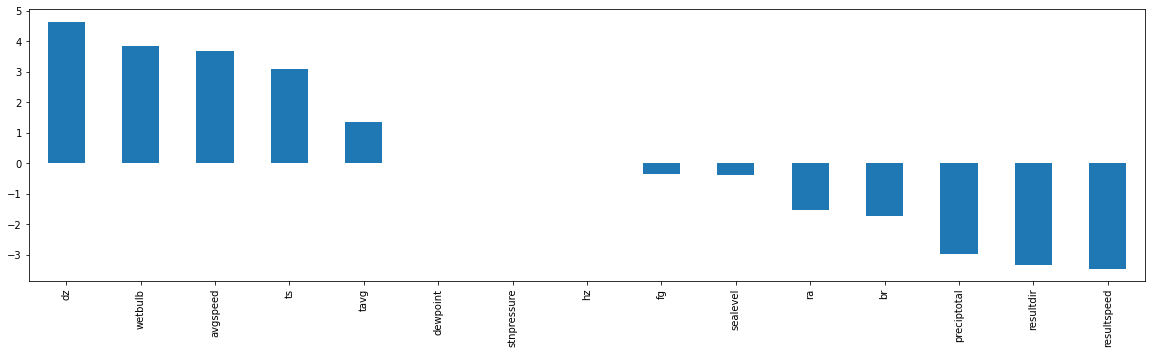

In [179]:
# to plot the series 
# too many variables, need to scale down the number of features 
plt.figure(figsize=(20,5))

col = X.columns
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

Checking code sum should only have these based on Daily Table format given by Kaggle 

`TS` - Thunderstorm

`RA` - Rain

`FG` - Fog

`FG+` - Heavy Fog 

`BR` - Mist

`DZ` - Drizzle 

`HZ` - Haze




In [180]:
heatmap_df = pd.DataFrame(impt_features)
heatmap_df = heatmap_df.rename(columns= {'ts' : 'thunderstorm', 'ra': 'rain', 'fg': 'fog', 'fg+': 'heavy_fog', 'br': 'mist', 'dz': 'drizzle', 'hz': 'haze'})

<AxesSubplot:>

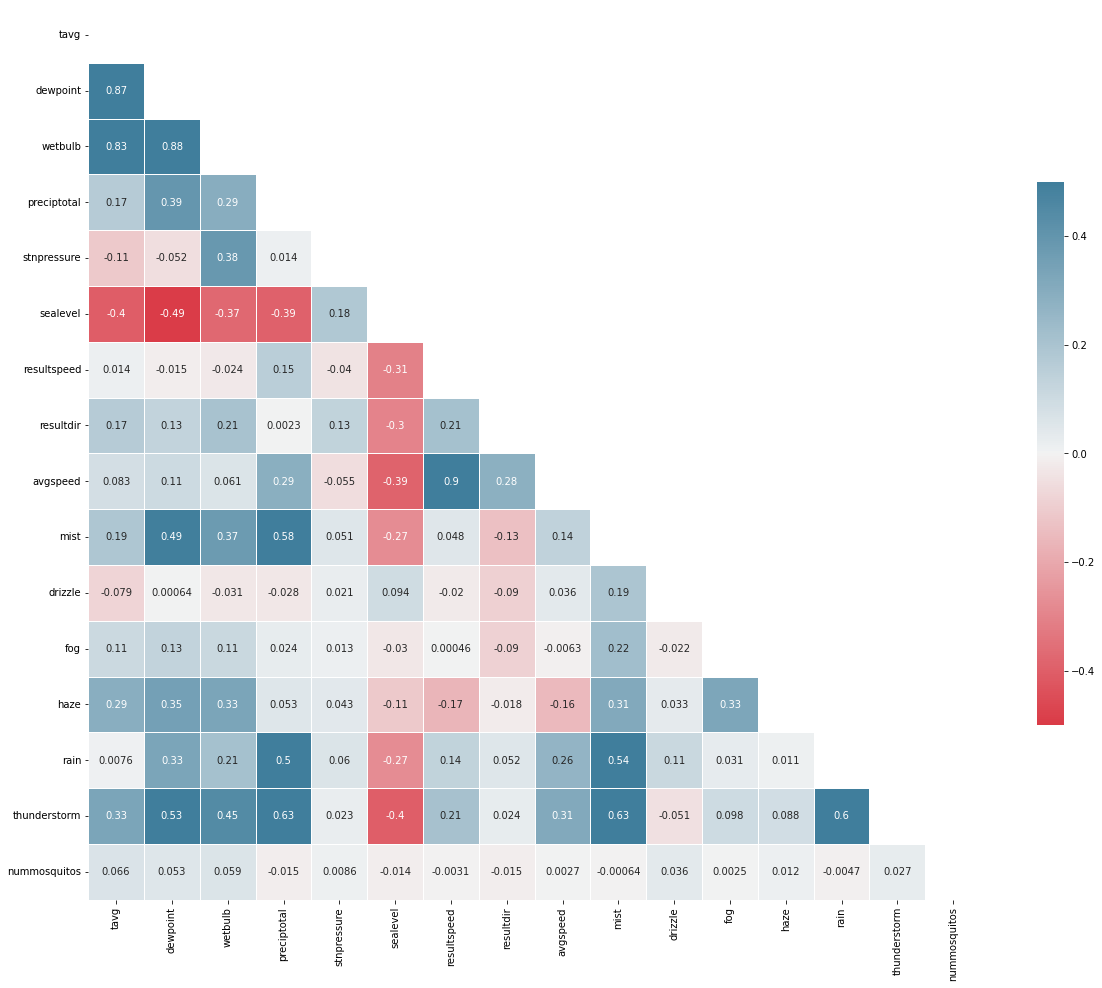

In [181]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(heatmap_df.corr()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(heatmap_df.corr(), mask=mask, cmap=cmap, vmax=0.5, vmin = -0.5,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

In [182]:
heatmap_df.corr()['nummosquitos'].sort_values(ascending = False)

nummosquitos    1.000000
tavg            0.065652
wetbulb         0.059446
dewpoint        0.052978
drizzle         0.035524
thunderstorm    0.027312
haze            0.011809
stnpressure     0.008643
avgspeed        0.002699
fog             0.002491
mist           -0.000642
resultspeed    -0.003099
rain           -0.004741
sealevel       -0.013790
preciptotal    -0.015122
resultdir      -0.015436
Name: nummosquitos, dtype: float64

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

From the heatmap, few observations were observed. 

1) Generally, having `thunderstorm`, `haze`, `fog`, `drizzle` have a positive correlation with number of mosquitoes while `heat`, `preciptotal`, `sealevel`, `resultdirection` has a slight negative correlation. These indicators will be strong in predicting if the area has a more 
2) We can see that `dewpoint` and `wetbulb` is highly correlated to `avg temperature`, suggesting that overall temperature has influence on the two variables. The `higher the dewpoint and temperature`, the `higher the relatively humidity` of the environment. Based on ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7068582/)), `humidity` shows `positive correlation` with the `numbers of species sampled from the traps`. 
3) The average speed has relative high correlation to weather conditions like `thunderstorm` and `rain` suggesting its used to help predict weather patterns and global climate. Although it might be not strongly correlated to number of mosquitos alongside witht resultspeed and resultdir, we should consider this in our modelling as based on ([source](https://kestrelmeters.com/blogs/news/the-science-of-mosquito-abatement#:~:text=Wind%20works%20as%20a%20natural,MPH%20wind%20gust%20is%20substantial)), strong wind serves as natural repellent as mosquitos cannot fly through strong wind. 



## Cleaning Spray Dataset

In [ ]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [ ]:
# convert all to lower case
spray.columns = [word.lower() for word in spray.columns]

In [ ]:
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

In [ ]:
# Change date column to be datetime dtype
spray['date'] = pd.to_datetime(spray['date']).dt.date

In [ ]:
spray['time'] = pd.to_datetime(spray['time'])

In [ ]:
# spray.set_index('date' ,inplace = True)
# spray.sort_index(inplace=True)

In [ ]:
for date in spray['date'].unique():
    print(date,'Earlist time:', spray[spray['date'] == date]['time'].min().time(),'Latest time:', spray[spray['date'] == date]['time'].max().time())

2011-08-29 Earlist time: 18:56:58 Latest time: 19:15:28
2011-09-07 Earlist time: 19:42:12 Latest time: 21:41:10
2013-07-17 Earlist time: 10:49:04 Latest time: 21:55:27
2013-07-25 Earlist time: 19:58:20 Latest time: 22:37:26
2013-08-08 Earlist time: 20:16:44 Latest time: 22:23:45
2013-08-15 Earlist time: 20:13:56 Latest time: 23:59:58
2013-08-16 Earlist time: 00:00:01 Latest time: 00:24:49
2013-08-22 Earlist time: 20:02:55 Latest time: 23:44:46
2013-08-29 Earlist time: 20:06:39 Latest time: 22:28:57
2013-09-05 Earlist time: 19:27:13 Latest time: 20:40:56


Time range for each of these days has many variations. will not be useful if merging with other dataset. hence need to remove column time. 


In [ ]:
spray.drop(columns = 'time', inplace= True)

In [ ]:
spray.isnull().sum()

date         0
latitude     0
longitude    0
dtype: int64

In [ ]:
spray.shape

(14835, 3)

In [ ]:
spray.drop_duplicates(subset = ['date', 'latitude', 'longitude'])

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14830,2013-09-05,42.006587,-87.812355
14831,2013-09-05,42.006192,-87.816015
14832,2013-09-05,42.006022,-87.817392
14833,2013-09-05,42.005453,-87.817423


### Cleaning Test Dataset

In [ ]:
# convert all to lower case
test.columns = [word.lower() for word in test.columns]

In [ ]:
# Change date column to be datetime dtype
test['date'] = pd.to_datetime(test['date'])

In [ ]:
#test.set_index('date' ,inplace = True)


In [ ]:
#test.sort_index(inplace=True)

In [ ]:
# resample by month 'M'
test.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
dtype: int64

### Merging Train and Spray

In [ ]:
spray

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14830,2013-09-05,42.006587,-87.812355
14831,2013-09-05,42.006192,-87.816015
14832,2013-09-05,42.006022,-87.817392
14833,2013-09-05,42.005453,-87.817423


In [ ]:
train

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


In [ ]:
spray

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858
...,...,...,...
14830,2013-09-05,42.006587,-87.812355
14831,2013-09-05,42.006192,-87.816015
14832,2013-09-05,42.006022,-87.817392
14833,2013-09-05,42.005453,-87.817423


In [ ]:
def spray_within_days(row, dist=0.001):
    
    # Accessing the tested mozzie trap's Latitude & Longitude.
    lat = row['latitude']
    lon = row['longitude']
    date = row['date']
    
    spray_filtered = spray[(spray['date'] == date)]
    
    for i in spray_filtered.index:
        
        # Calculating euclidean distance between the row's location and the spray's location (using values in Latitude and Longitude columns)
        spray_dist = ((spray.loc[i, 'latitude'] - lat) ** 2 + (spray.loc[i, 'longitude'] - lon) ** 2) ** 0.5
        
        # So if the calculated distance is <= distance value given as input, the tested trap is considered sprayed, so return 1.
        if spray_dist <= dist:
            return 1
    
    # Return 0 (mozzie trap not sprayed) if spray_dist > dist.
    return 0

In [ ]:
train['sprayed'] = train.apply(spray_within_days, axis=1)

In [ ]:
test['sprayed'] = test.apply(spray_within_days, axis=1)

KeyboardInterrupt: 

In [ ]:
(train['sprayed'] == 1).sum()

10

In [ ]:
train.loc[(train['sprayed'] == 1)]

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvcount,wnvpresent,date_col,month_num,month,sprayed
7249,2013-07-25,"3900 North Springfield Avenue, Chicago, IL 606...",CULEX PIPIENS/RESTUANS,39,N SPRINGFIELD AVE,T228,"3900 N SPRINGFIELD AVE, Chicago, IL",41.951866,-87.725057,8,24,0,0,2013-07-25,7,July,1
7527,2013-08-08,"2800 North Francisco Avenue, Chicago, IL 60618...",CULEX PIPIENS,28,N FRANCISCO AVE,T147,"2800 N FRANCISCO AVE, Chicago, IL",41.932094,-87.700117,8,5,0,0,2013-08-08,8,Aug,1
7656,2013-08-15,"1300 North Laramie Avenue, Chicago, IL 60651, USA",CULEX PIPIENS/RESTUANS,13,N LARAMIE AVE,T230,"1300 N LARAMIE AVE, Chicago, IL",41.904194,-87.756155,9,15,1,1,2013-08-15,8,Aug,1
7746,2013-08-15,"7000 West Armitage Avenue, Chicago, IL 60707, USA",CULEX PIPIENS,70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,9,1,1,2013-08-15,8,Aug,1
7747,2013-08-15,"7000 West Armitage Avenue, Chicago, IL 60707, USA",CULEX PIPIENS/RESTUANS,70,W ARMITAGE AVENUE,T151,"7000 W ARMITAGE AVENUE, Chicago, IL",41.916265,-87.800515,8,11,0,0,2013-08-15,8,Aug,1
7910,2013-08-22,"East 91st Place, Chicago, IL, USA",CULEX PIPIENS,65,E 91ST PL,T227,"6500 E 91ST PL, Chicago, IL",41.728495,-87.600963,5,5,0,0,2013-08-22,8,Aug,1
7911,2013-08-22,"East 91st Place, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,65,E 91ST PL,T227,"6500 E 91ST PL, Chicago, IL",41.728495,-87.600963,5,22,1,1,2013-08-22,8,Aug,1
7912,2013-08-22,"East 91st Place, Chicago, IL, USA",CULEX RESTUANS,65,E 91ST PL,T227,"6500 E 91ST PL, Chicago, IL",41.728495,-87.600963,5,16,0,0,2013-08-22,8,Aug,1
7991,2013-08-29,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,39,1,1,2013-08-29,8,Aug,1
7992,2013-08-29,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,11,0,0,2013-08-29,8,Aug,1


In [ ]:
train.loc[train['trap'] == 'T231']

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvcount,wnvpresent,date_col,month_num,month,sprayed
4795,2011-06-17,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-06-17,6,June,0
5081,2011-07-11,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-07-11,7,July,0
5082,2011-07-11,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,2,0,0,2011-07-11,7,July,0
5211,2011-07-15,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-07-15,7,July,0
5363,2011-07-25,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-07-25,7,July,0
5364,2011-07-25,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,3,0,0,2011-07-25,7,July,0
5365,2011-07-25,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-07-25,7,July,0
5941,2011-08-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-08-26,8,Aug,0
6155,2011-09-12,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-09-12,9,Sept,0
6364,2011-09-23,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.98728,-87.666066,8,1,0,0,2011-09-23,9,Sept,0
